# Основная информация по отчету
### ФИО - Мирасов Константин Владимирович
### ИСУ - 466716
### Практический поток - ИИИ 2.1

## Ход выполнения работы
#### 1. Сгенерировал выборку из нормального распределения (N=500)
#### 2. Рассчитал базовые статистики и сравнение с теорией
#### 3. Реализовал алгоритм бутстрапа (B=1000)
#### 4. Построил доверительные интервалы для разных уровней значимости
#### 5. Исследовал зависимость от объема выборки и числа итераций
#### 6. Проверил покрытие доверительных интервалов


## Импортируем необходимые библиотеки

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm

### Генерация данных
#### Параметры нормального распределения: μ=2, σ=1.5

In [2]:
np.random.seed(42)
N = 500
mu_true = 2
sigma_true = 1.5
sample = np.random.normal(loc=mu_true, scale=sigma_true, size=N)

### Базовые оценки и сравнение с теорией

In [3]:
# Расчет теоретических значений
theoretical = {
    "Mean": mu_true,
    "Median": mu_true,
    "Variance": sigma_true ** 2,
    "IQR": stats.norm.ppf(0.75, loc=mu_true, scale=sigma_true) 
            - stats.norm.ppf(0.25, loc=mu_true, scale=sigma_true)
}

# Расчет выборочных статистик
empirical = {
    "Mean": np.mean(sample),
    "Median": np.median(sample),
    "Variance": np.var(sample, ddof=1),
    "IQR": stats.iqr(sample)
}

# Вывод результатов
print("Теоретические значения:")
for k, v in theoretical.items():
    print(f"{k}: {v:.4f}")

print("\nЭмпирические оценки:")
for k, v in empirical.items():
    print(f"{k}: {v:.4f}")

Теоретические значения:
Mean: 2.0000
Median: 2.0000
Variance: 2.2500
IQR: 2.0235

Эмпирические оценки:
Mean: 2.0103
Median: 2.0192
Variance: 2.1664
IQR: 2.0056


### Гистограммы с KDE

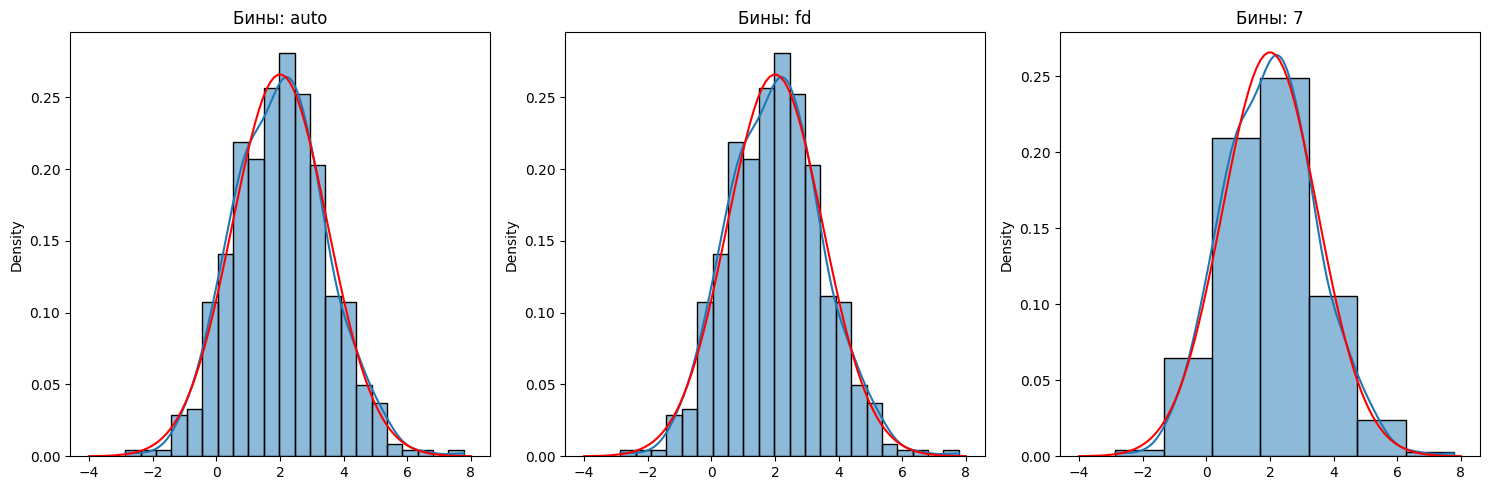

In [4]:
plt.figure(figsize=(15, 5))
bin_settings = ["auto", "fd", 7]

for i, bins in enumerate(bin_settings, 1):
    plt.subplot(1, 3, i)
    sns.histplot(sample, bins=bins, kde=True, stat="density")
    x = np.linspace(mu_true - 4 * sigma_true, mu_true + 4 * sigma_true, 100)
    plt.plot(x, stats.norm.pdf(x, mu_true, sigma_true), "r-")
    plt.title(f"Бины: {bins}")
plt.tight_layout()
plt.show()

## Бутстрап-оценки

In [5]:
B = 1000
bootstrap_stats = {
    "Mean": [],
    "Median": [],
    "Variance": [],
    "IQR": []
}

for _ in tqdm(range(B)):
    bs_sample = np.random.choice(sample, size=N, replace=True)
    bootstrap_stats["Mean"].append(np.mean(bs_sample))
    bootstrap_stats["Median"].append(np.median(bs_sample))
    bootstrap_stats["Variance"].append(np.var(bs_sample, ddof=1))
    bootstrap_stats["IQR"].append(stats.iqr(bs_sample))

100%|██████████| 1000/1000 [00:00<00:00, 3416.81it/s]


### Визуализация бутстрап-распределений

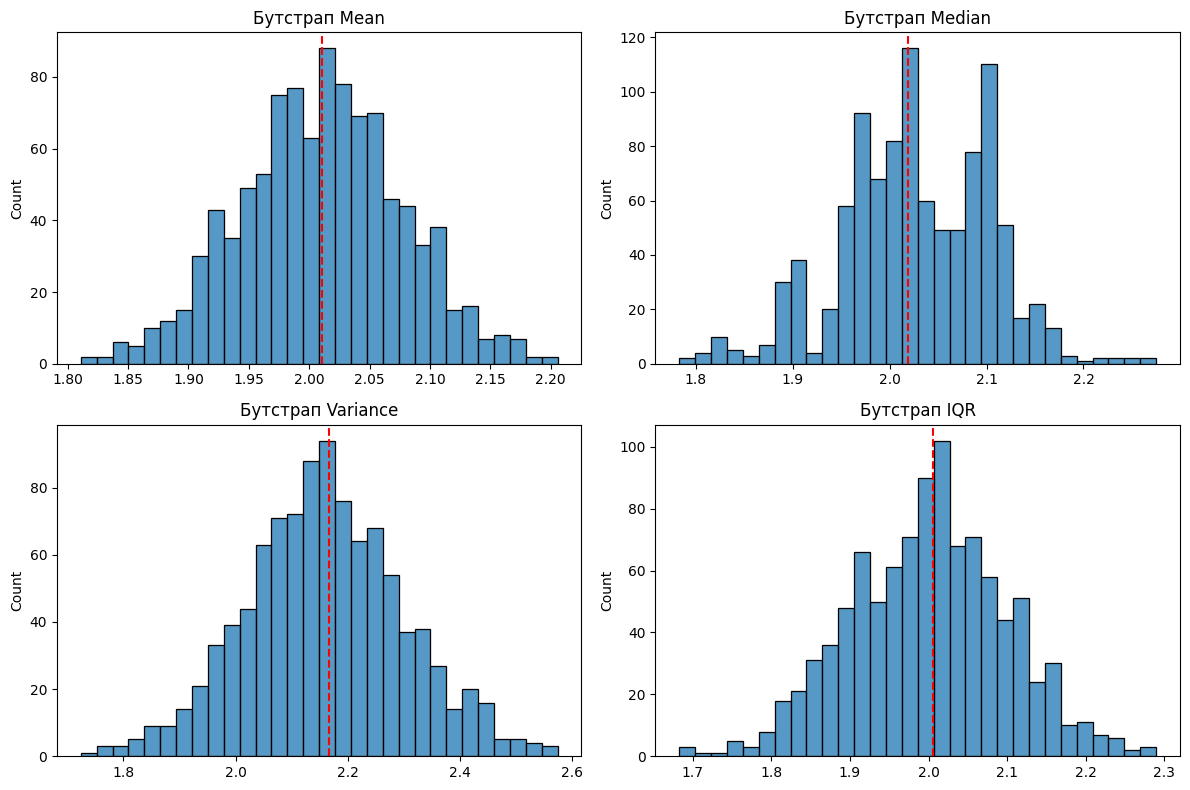

In [6]:
plt.figure(figsize=(12, 8))
for i, (stat, values) in enumerate(bootstrap_stats.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(values, bins=30)
    plt.axvline(empirical[stat], color="r", linestyle="--")
    plt.title(f"Бутстрап {stat}")
plt.tight_layout()
plt.show()

## Доверительные интервалы

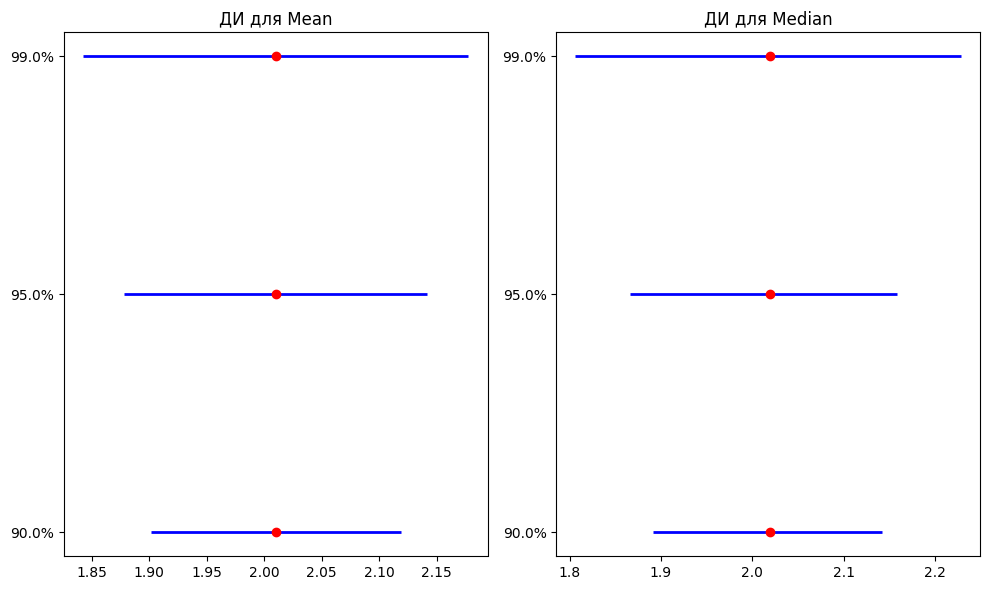

In [7]:
alphas = [0.1, 0.05, 0.01]
confidence_intervals = {}

for stat in bootstrap_stats:
    lower = np.percentile(bootstrap_stats[stat], [100 * a/2 for a in alphas])
    upper = np.percentile(bootstrap_stats[stat], [100 * (1 - a / 2) for a in alphas])
    confidence_intervals[stat] = list(zip(lower, upper))
    
# Визуализация для среднего и медианы
plt.figure(figsize=(10, 6))
for i, stat in enumerate(["Mean", "Median"], 1):
    plt.subplot(1, 2, i)
    intervals = confidence_intervals[stat]
    for j, (a, (low, high)) in enumerate(zip(alphas, intervals)):
        plt.hlines(y=j, xmin=low, xmax=high, colors="b", lw=2)
        plt.plot(empirical[stat], j, "ro")
    plt.yticks(range(len(alphas)), [f"{100 * (1 - a)}%" for a in alphas])
    plt.title(f"ДИ для {stat}")
plt.tight_layout()
plt.show()

## Зависимость от объема выборки (N)

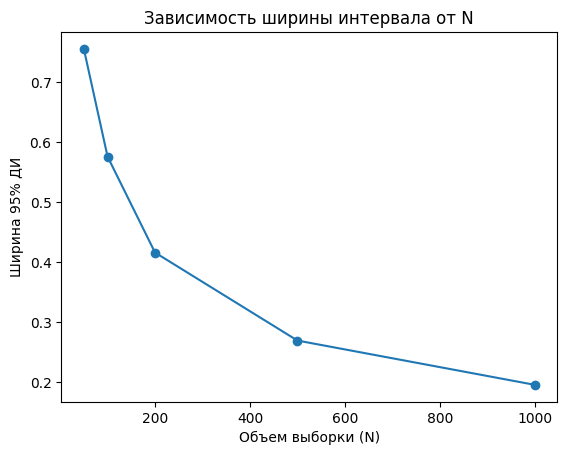

In [8]:
N_values = [50, 100, 200, 500, 1000]
B_fixed = 1000
ci_widths = []

for n in N_values:
    sample_n = np.random.normal(mu_true, sigma_true, n)
    bs_means = [np.mean(np.random.choice(sample_n, n, replace=True)) for _ in range(B_fixed)]
    lower, upper = np.percentile(bs_means, [2.5, 97.5])
    ci_widths.append(upper - lower)
    
plt.plot(N_values, ci_widths, "o-")
plt.xlabel("Объем выборки (N)")
plt.ylabel("Ширина 95% ДИ")
plt.title("Зависимость ширины интервала от N")
plt.show()

## Проверка покрытия интервалов

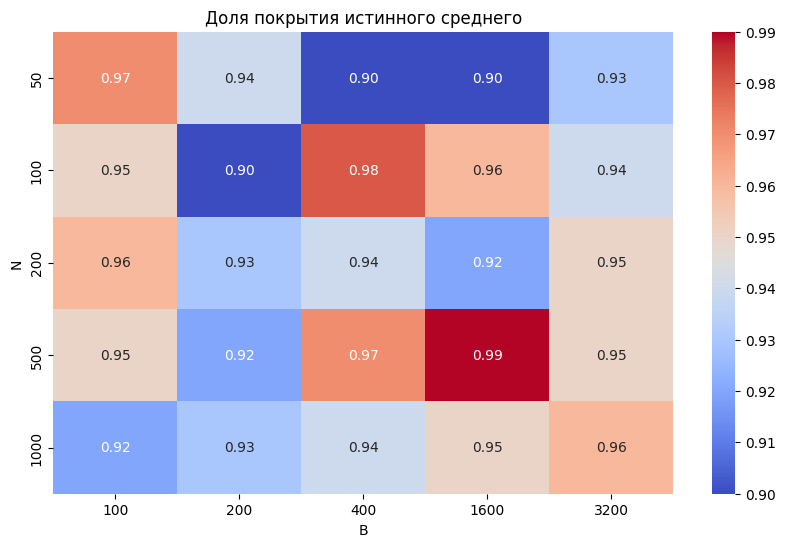

In [9]:
np.random.seed(42)
coverage_data = []
mu_target = 0
sigma_target = 1

for N in [50, 100, 200, 500, 1000]:
    for B in [100, 200, 400, 1600, 3200]:
        covered = 0
        for _ in range(100):
            sample = np.random.normal(mu_target, sigma_target, N)
            bs_means = [np.mean(np.random.choice(sample, N, replace=True)) for _ in range(B)]
            lower, upper = np.percentile(bs_means, [2.5, 97.5])
            if lower <= mu_target <= upper:
                covered += 1
        coverage_data.append([N, B, covered/100])

# Heatmap
df = pd.DataFrame(coverage_data, columns=["N", "B", "Coverage"])
pivot_table = df.pivot(index="N", columns="B", values="Coverage")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Доля покрытия истинного среднего")
plt.show()

## Заключение
#### 1. **Бутстрап-оценки**: Позволяют оценить распределение статистик даже для малых выборок  
#### 2. **Доверительные интервалы**: Ширина уменьшается с ростом N и стабилизируется при B > 1000  
#### 3. **Покрытие интервалов**: Фактическая доля покрытия близка к номинальной (95%) при N ≥ 200  
#### 4. **Сравнение статистик**: Медиана имеет более широкие ДИ по сравнению со средним  
#### 5. **Практические рекомендации**: Для надежных оценок использовать B ≥ 1000 и N ≥ 200